In [0]:
%matplotlib inline

# Downgrading torch and vision versions
 The default torch and vision versions showed warning for all the 25,000 images which super spammed the output.


In [3]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 35.1MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


# Imports

In [0]:
import os
import io
import numpy as np
import tarfile
import PIL

from fastai.vision import *

# Downloading dataset from source

In [0]:
os.environ['KAGGLE_USERNAME'] = "ferozkhan05"
os.environ['KAGGLE_KEY'] = "7881a70c1ba66b732f409f8efa63df8a"

In [6]:
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [00:32<00:00, 45.8MB/s]
100% 1.76G/1.76G [00:32<00:00, 58.9MB/s]


In [49]:
! unzip -q lung-and-colon-cancer-histopathological-images.zip;


replace lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Moving to a common directory
 Lung and colon images
 from two different directory is moved to common directory.


In [0]:
mkdir Alldataset

In [0]:
mv /content/lung_colon_image_set/colon_image_sets/colon_aca /content/Alldataset #colon_aca

In [0]:
mv /content/lung_colon_image_set/colon_image_sets/colon_n /content/Alldataset   #colon_n

In [0]:
mv /content/lung_colon_image_set/lung_image_sets/lung_aca /content/Alldataset   #lung_aca

In [0]:
mv /content/lung_colon_image_set/lung_image_sets/lung_n /content/Alldataset     #lung_n 

In [0]:
mv /content/lung_colon_image_set/lung_image_sets/lung_scc /content/Alldataset   #lung_scc

# Training the Classifier using fastai

In [0]:
path = Path("/content/Alldataset")

In [0]:
classes = os.listdir('/content/Alldataset')

In [17]:
classes

['lung_scc', 'lung_aca', 'colon_aca', 'lung_n', 'colon_n']

In [18]:
for c in classes:
    verify_images(path/c, delete=True, max_workers=8)

In [0]:
np.random.seed(5)
src = (ImageList.from_folder(path)
      .split_by_rand_pct(valid_pct=0.2)
      .label_from_folder())

In [0]:
tfdm = get_transforms(max_rotate=25, max_zoom=1.3, max_warp=0.4)

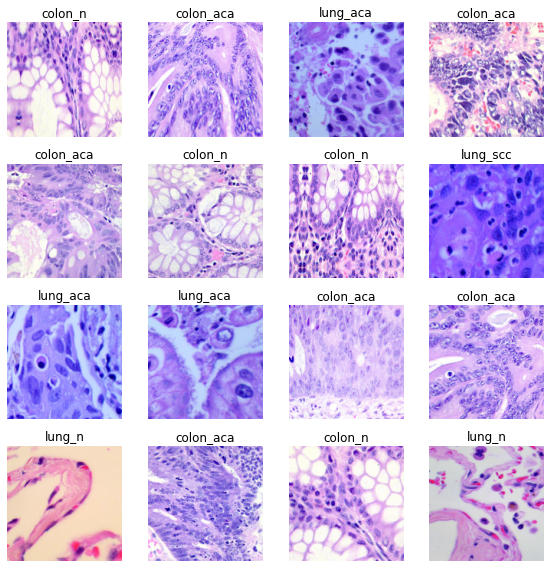

In [21]:
 data =(src.transform(tfdm, size=150)
         .databunch(bs=256)
         .normalize(imagenet_stats))
 
 data.show_batch(rows=4, figsize=(8,8))

In [22]:
learner34 = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


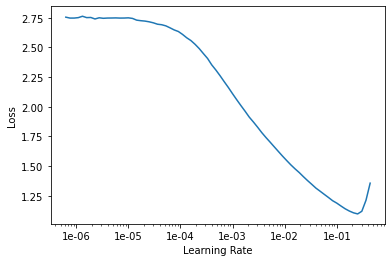

In [23]:
learner34.lr_find()
learner34.recorder.plot()

In [0]:
lr = 1e-03

In [25]:
learner34.fit_one_cycle(10, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.948788,0.197304,0.934400,08:28
1,0.390524,0.109540,0.959600,08:26
2,0.238462,0.084670,0.966800,08:27
3,0.172640,0.064525,0.973400,08:31
4,0.134773,0.059183,0.974200,08:27
5,0.120810,0.048939,0.980200,08:32
6,0.104290,0.043515,0.980600,08:30
7,0.097266,0.043351,0.982200,08:41
8,0.091128,0.041499,0.982400,08:35
9,0.090527,0.041045,0.982400,08:30


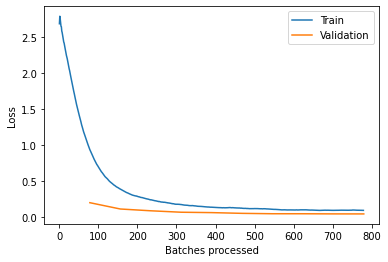

In [26]:
learner34.recorder.plot_losses()

In [0]:
learner34.save('resnet34-prototype1')

In [28]:
interp = ClassificationInterpretation.from_learner(learner34)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

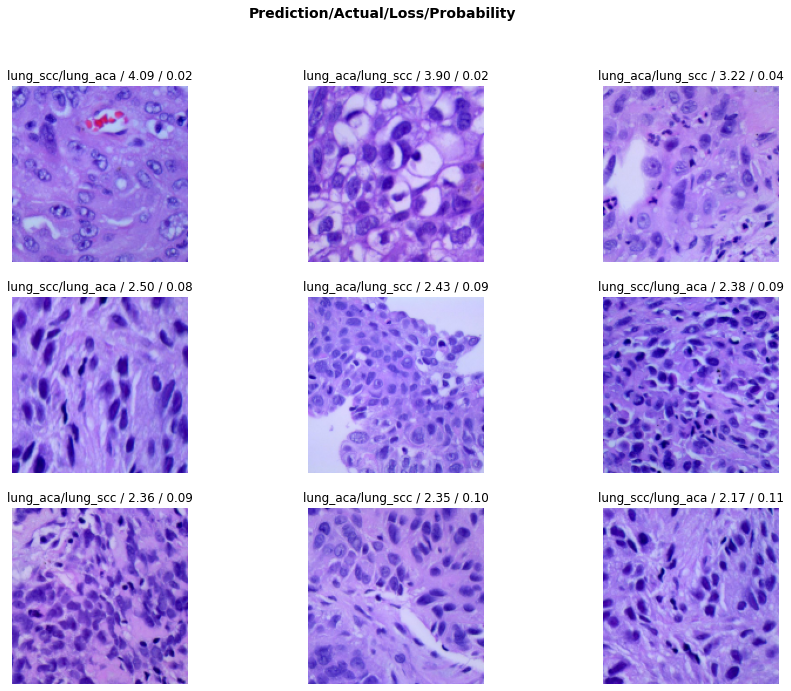

In [29]:
interp.plot_top_losses(9, figsize=(15,11))

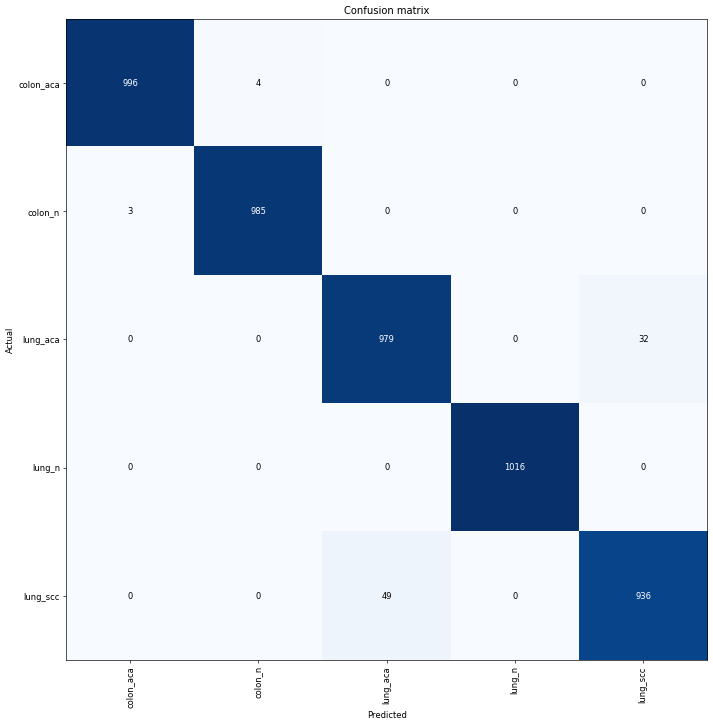

In [30]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [31]:
interp.most_confused(min_val=1)

[('lung_scc', 'lung_aca', 49),
 ('lung_aca', 'lung_scc', 32),
 ('colon_aca', 'colon_n', 4),
 ('colon_n', 'colon_aca', 3)]

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


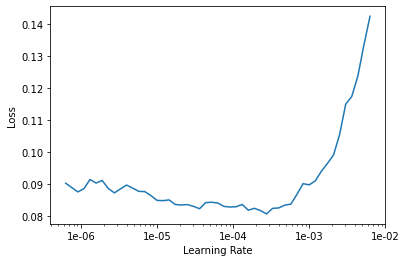

In [32]:
learner34.unfreeze()
learner34.lr_find()
learner34.recorder.plot()

In [33]:
learner34.fit_one_cycle(3, max_lr=slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.071102,0.021408,0.991800,08:35
1,0.046765,0.012238,0.995800,08:35
2,0.036043,0.009961,0.996800,08:43


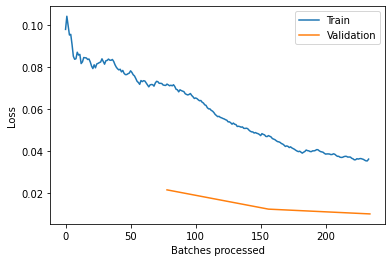

In [34]:
learner34.recorder.plot_losses()

In [35]:
interp = ClassificationInterpretation.from_learner(learner34)

In [36]:
interp.most_confused(min_val=1)

[('lung_scc', 'lung_aca', 10), ('lung_aca', 'lung_scc', 6)]

In [37]:
val_preds,val_targets = learner34.get_preds()

In [38]:
val_preds

tensor([[1.0000e+00, 1.0134e-07, 2.8323e-10, 9.4424e-12, 1.5563e-10],
        [1.5685e-05, 9.9986e-01, 6.6263e-06, 3.9312e-05, 7.9570e-05],
        [9.7397e-11, 7.6815e-10, 3.2353e-08, 1.0000e+00, 9.5840e-10],
        ...,
        [1.4742e-07, 5.9863e-07, 9.9991e-01, 1.9444e-05, 7.3135e-05],
        [3.4546e-08, 1.0000e+00, 1.1473e-09, 2.1657e-09, 1.3185e-09],
        [5.0515e-08, 1.0000e+00, 5.7371e-08, 3.0264e-08, 3.0232e-09]])

In [39]:
val_targets

tensor([0, 1, 3,  ..., 2, 1, 1])

In [0]:
val_preds = val_preds.argmax(dim=1)

In [41]:
val_preds

tensor([0, 1, 3,  ..., 2, 1, 1])

In [43]:
data.classes

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

In [44]:
from sklearn.metrics import classification_report

print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00       988
           2       0.99      0.99      0.99      1011
           3       1.00      1.00      1.00      1016
           4       0.99      0.99      0.99       985

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

